In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 20 # hz
pg_fr = 8 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [3]:
disp_figs= True

In [4]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [5]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

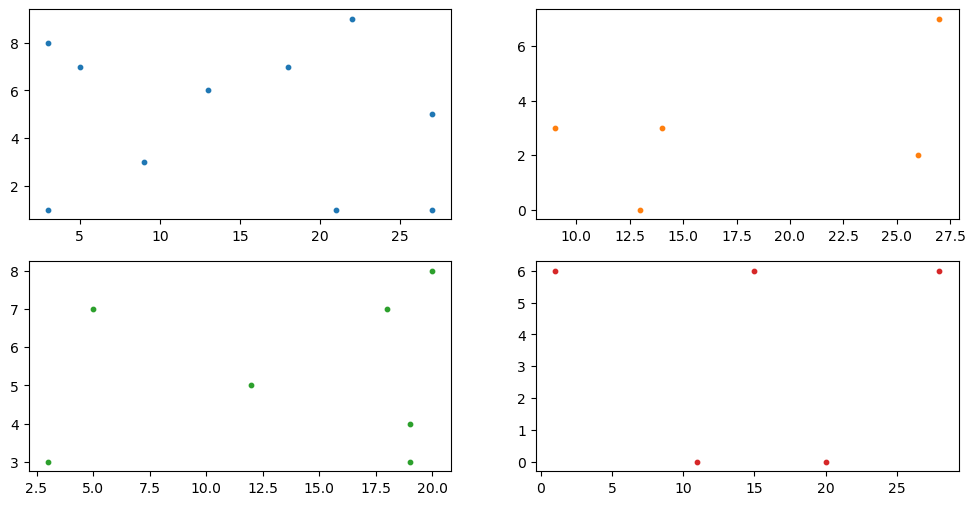

In [6]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [7]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

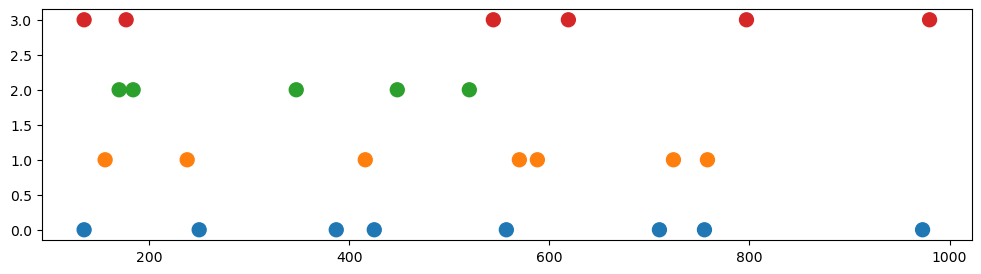

In [8]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times


In [9]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

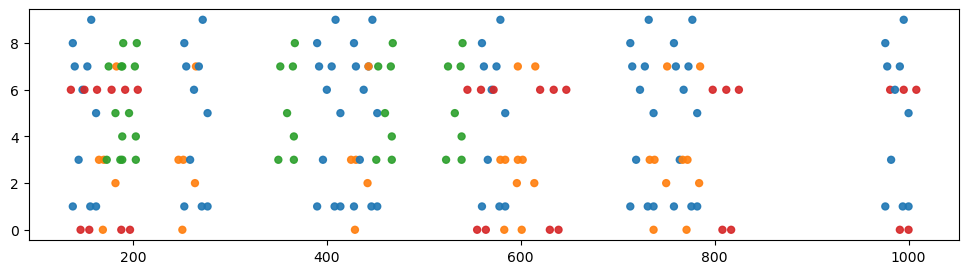

In [15]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# lif neuron


In [70]:
colors = np.array(['#1f77b4', '#ff7f0e','#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#7f7f7f', '#bcbd22', '#17becf'])


In [115]:
lif = np.zeros((T))
synapse_reps = 5 # arbitrary
delay_range = (10,20)
afferent_id = np.arange(N).tolist() * synapse_reps
afferent_id = np.array(afferent_id)
delays = np.random.randint(*delay_range,(afferent_id.shape))
amplitudes = 0.1*np.ones(len(delays))
afferents = np.zeros((3,len(afferent_id)))
afferents[0,:] = afferent_id
afferents[1,:] = delays
afferents[2,:] = amplitudes

A_delay = np.zeros((len(afferent_id),A_dense.shape[1]))
for j,i in enumerate(afferent_id):
    A_delay[j] = np.concatenate((delays[i]*[0],A_dense[i,:-delays[i]]))
    
    # STDP parameters
t1, t2, t3, t4 = 0.025, 0.025, 1 , 0.025
a2minus,a2plus,a3minus,a3plus = 0.5, 10, 0.5, 10
o1 = np.zeros((afferents.shape[1]))
o2 = np.zeros((afferents.shape[1]))
r1 = np.zeros((afferents.shape[1]))
r2 = np.zeros((afferents.shape[1]))


In [118]:
spikes = np.zeros((T+D))
th=1

debug_amplitudes = np.zeros((T+D,len(amplitudes)))

I = np.zeros(len(afferents[2]))
for t in range(T+D):
    if np.isnan(np.sum(I)):
        break
    I = A_delay.T[t,:]*afferents[2]
    if np.sum(I) > th:
        spikes[t]=1
    
    # ltp 
    o1 = o1 * (22/23)
    o2 = o2 * (988/999)
    r1 = r1 * (22/23)
    r2 = r2 * (22/23)
    r1 += 1 * spikes[t]
    afferents[2] -= o1 * ( a2minus + a3minus*r2) * spikes[t]
    r2 += 1 * spikes[t]
        
    o1+= 1*I
    afferents[2] += (r1 * (a2plus+a3plus * o2)) * I
    o2+= 1*I
    
    debug_amplitudes[t,:] = afferents[2]
    


C:\Users\miles\AppData\Local\Temp\ipykernel_17380\635577707.py:24: RuntimeWarning: overflow encountered in multiply
  afferents[2] += (r1 * (a2plus+a3plus * o2)) * I
C:\Users\miles\AppData\Local\Temp\ipykernel_17380\635577707.py:10: RuntimeWarning: invalid value encountered in multiply
  I = A_delay.T[t,:]*afferents[2]


In [119]:
I

array([ 0., -0.,  0., nan,  0.,  0.,  0., nan, -0., -0.,  0., -0.,  0.,
       nan,  0.,  0.,  0., nan, -0., -0.,  0., -0.,  0., nan,  0.,  0.,
        0., nan, -0., -0.,  0., -0.,  0., nan,  0.,  0.,  0., nan, -0.,
       -0.,  0., -0.,  0., nan,  0.,  0.,  0., nan, -0., -0.])

In [107]:
I

array([nan, nan,  0., nan,  0.,  0., nan, nan,  0.,  0., nan, nan,  0.,
       nan,  0.,  0., nan, nan,  0.,  0., nan, nan,  0., nan,  0.,  0.,
       nan, nan,  0.,  0., nan, nan,  0., nan,  0.,  0., nan, nan,  0.,
        0., nan, nan,  0., nan,  0.,  0., nan, nan,  0.,  0.])

In [104]:
    
plt.figure()
plt.plot(np.arange(T+D), debug_amplitudes[:,10])
plt.show()

In [77]:
%matplotlib qt
fig,ax = plt.subplot_mosaic('AAAB;CCCB')
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]])
ax['C'].plot(spikes)
ax['B'].scatter(afferents[1],afferents[0],alpha=afferents[2])
plt.show()

In [ ]:
   def __ltp(self, a2plus, a2minus, a3plus, a3minus, o1, o2, r1, r2, tr1, tr2, to1,to2):
        if (self.input_neuron.cell_type == 'excitatory' or input_neuron.cell_type == 'input') and self.output_neuron.cell_type == 'excitatory':
            o1 = o1 * (22/23)
            o2 = o2 * (988/999)
            r1 = r1 * (22/23)
            r2 = r2 * (22/23)
            if self.input_neuron.fire:
                self.r1 += 1
                self.A -= self.o1 * ( a2minus + a3minus*r2)
                self.r2 += 1
            elif self.output_neuron.fire:
                self.o1+=1
                self.A +=self.r1 * ( a2plus + a3plus * o2)
                self.o2+=1
            return(self.A)
        else:
            return self.w_init